# Local level model: inference and forecasts

Basic state-space model with measurement error and an AR(1) latent process.

$$y_t = \gamma + \eta z_t + \epsilon_t, \quad \epsilon_t \sim N_{0,\sigma^2}, \quad t=1,\dots,\tau$$
$$z_t = \rho z_{t-1} + \nu_t\quad \nu_t \sim N_{0,1}, \quad t=2,\dots,\tau$$
$$z_1 \sim N_{0, (1+\rho^2)^{-1/2}} $$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Executive summary

For some reason, a 'worse' elbo approximation performs much better. I am still trying to work out why. It could be a random chance/overfit, or it could be something a bit more general.

In the example given in this notebook, the 'good' VI approximation would be unusable in practice, whereas the 'bad' one is actually quite reasonable. What gives?

## Preliminaries

In [1]:
from ptvi import plot_dens, LocalLevelModel, sgvb
import torch
import pandas as pd
pd.set_option('precision', 2)
seed = 123

Define the true parameter values and generate data.

In [2]:
γ0, η0, σ0, ρ0 = 0., 2., 1.5, 0.92

In [3]:
torch.manual_seed(seed)
true_params = dict(γ=γ0, η=η0, σ=σ0, ρ=ρ0)
model = LocalLevelModel(input_length=100)
y, z = model.simulate(**true_params)

## Approximate inference (analytic entropy term)

Our inference procedure is quick, but frankly not super great.

We will do inference twice, with two different elbo estimates. Here we do ADVI, so our elbo is estimated with an analytic entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M 
    p(y, \zeta^{(i)}) - 
    \mathbb{E}_{q_{u,L}} \left[ q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. For convenience, we choose $M=1$.

In [16]:
fit = sgvb(model, y, sim_entropy=False, lr=0.1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured ADVI for Local level model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=0.1, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo = -977.45
       1. smoothed elbo =-1186.44
       2. smoothed elbo =-1177.15
       4. smoothed elbo =-1722.41
       8. smoothed elbo =-1492.18
      16. smoothed elbo =-8150.24
      32. smoothed elbo =-11609.64
      64. smoothed elbo =-15958.98
     128. smoothed elbo =-7900.79
     256. smoothed elbo =-6496.65
     512. smoothed elbo =-7527.81
    1024. smoothed elbo =-1982.20
    2048. smoothed elbo =-1510.16
    4096. smoothed elbo =-4902.48
    8192. smoothed elbo =-1527.21
   16384. smoothed elbo =  274.06
Stop

In [5]:
fit.summary()

,mean,sd
γ,0.18,0.14
η,3.09,2.85
σ,2.87,1.08
ρ,0.75,0.02


Note the model's overconfidence about the latent state. You can barely even see the standard deviation band around the blue estimated state.

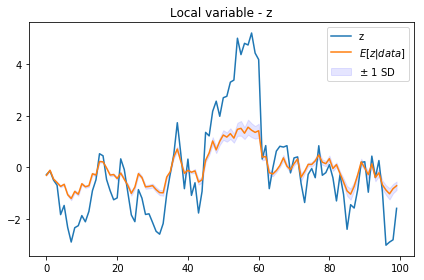

In [6]:
fit.plot_latent(z=z.numpy(), include_data=True)

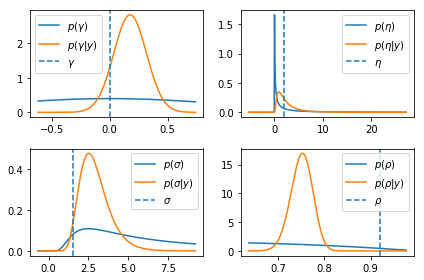

In [7]:
fit.plot_global_marginals(**true_params)

### Forecasts

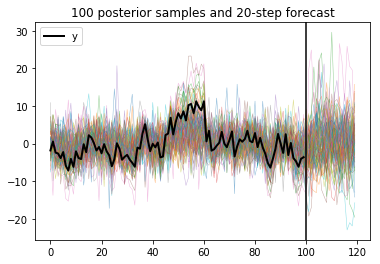

In [8]:
fit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

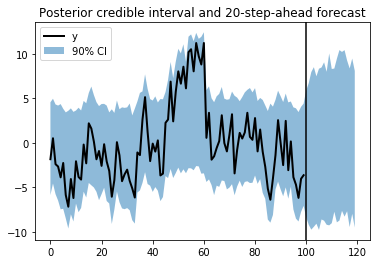

In [9]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Approximate inference (stochastic entropy term)

Here, our elbo is estimated by simulating the entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M \left[
    p(y, \zeta^{(i)}) - q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. For convenience, we choose $M=1$.

**LOOK AT HOW MUCH BETTER THE APPROXIMATION -- AND FORECASTS -- ARE!**

In [10]:
torch.manual_seed(seed)
fit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference for Local level model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-26679.95
       1. smoothed elbo =-26918.20
       2. smoothed elbo =-24366.35
       4. smoothed elbo =-20956.88
       8. smoothed elbo =-19059.64
      16. smoothed elbo =-9249.21
      32. smoothed elbo =-3199.14
      64. smoothed elbo =-27466.58
     128. smoothed elbo =-10415.98
     256. smoothed elbo =-3078.64
     512. smoothed elbo =-3883.01
    1024. smoothed elbo =-1133.56
    2048. smoothed elbo = -313.86
    4096. smoothed elbo = -290.63
    8192. smoothed elbo = -261.58
Stopping heuristic crit

In [11]:
fit.summary()

,mean,sd
γ,-0.07,0.54
η,1.61,0.20
σ,2.05,0.30
ρ,0.88,0.04


The model is now less overconfident about the latent state!

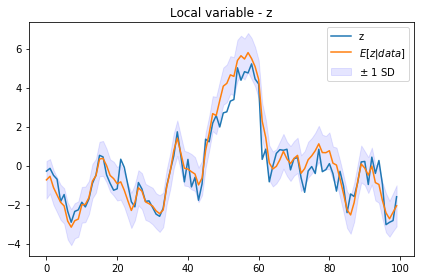

In [12]:
fit.plot_latent(z=z)

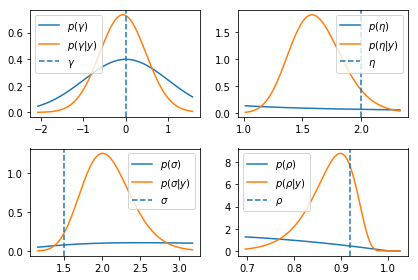

In [13]:
fit.plot_global_marginals(**true_params)

### Forecasts

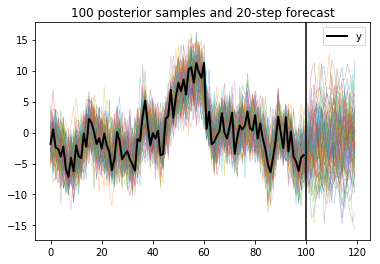

In [14]:
fit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

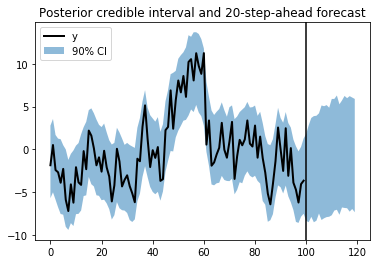

In [15]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)